### Hypothesis 3: Idiosyncratic risk impacts default probability differently than systemic risk.

# DELETE LATER
Basic Idea:
- $ R_{firm} = \alpha + \beta R_{market} + \epsilon $
- $ \beta $ is systemic risk
- std($\epsilon$) is idiosyncratic volatility which can be used as a proxy for idiosyncratic risk
- take average PD for each firm
- $PD_i = \alpha + \beta_1 Systemic_i + \beta_2 Idiosyncratic_i + \epsilon_i $ \
Expected result: both betas to be positive. Beta 1 to be larger.


In [55]:
import pandas as pd 
import numpy as np 
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [ ]:
data = pd.read_csv(r'../data/clean_data.csv')
data['tic'].unique()
testing = data[data['tic'] == 'ADP']
testing = testing.set_index('date')
testing.index = pd.to_datetime(testing.index)

test_logreturns = testing['log_return']

In [47]:
data['tic'].unique()


array(['AAPL', 'ABT', 'ACN', 'ADBE', 'ADP', 'AIG', 'AMAT', 'AMGN', 'AMT',
       'AMZN', 'AXP', 'BA', 'BAC', 'BKNG', 'BLK', 'BMY', 'BNS', 'BP',
       'BRK.B', 'C', 'CAT', 'CB', 'CL', 'CMCSA', 'CNI', 'COP', 'COST',
       'CSCO', 'CVS', 'CVX', 'DE', 'DHR', 'DIS', 'DUK', 'EBAY', 'ELV',
       'GE', 'GILD', 'GS', 'HD', 'HON', 'HPQ', 'IBM', 'INTC', 'INTU',
       'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'LOW', 'MCD', 'MDLZ', 'MDT',
       'MET', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NEE', 'NFLX', 'NKE',
       'NVDA', 'ORCL', 'OXY', 'PEP', 'PFE', 'PG', 'PNC', 'QCOM', 'RTX',
       'RY', 'SBUX', 'SCHW', 'SLB', 'SO', 'SU', 'SYK', 'T', 'TD', 'TGT',
       'TJX', 'TMO', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'VZ', 'WBA',
       'WFC', 'WMT', 'XOM'], dtype=object)

In [11]:
spy_csv = pd.read_csv(r'../hypothesis-2/SPY.csv')
spy_csv['log_return'] = np.log(spy_csv['PRC'] / spy_csv['PRC'].shift(1))
spy_csv = spy_csv.set_index('date')
spy_csv.index = pd.to_datetime(spy_csv.index)

spy_logreturns = spy_csv['log_return'].dropna()

In [12]:
spy_logreturns, test_logreturns = spy_logreturns.align(test_logreturns, join = 'inner', axis = 0)

In [13]:

X = sm.add_constant(spy_logreturns)
model = sm.OLS(test_logreturns, X)
results = model.fit()

print(results.summary())
_, beta = results.params
print(beta)
epsilon_std = np.std(results.resid)

                            OLS Regression Results                            
Dep. Variable:             log_return   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                     5079.
Date:                Sat, 26 Apr 2025   Prob (F-statistic):               0.00
Time:                        22:35:33   Log-Likelihood:                 12666.
No. Observations:                3970   AIC:                        -2.533e+04
Df Residuals:                    3968   BIC:                        -2.532e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      1.192      0.2

In [ ]:
window_size = 252 * 3 

rolling_beta = []
rolling_idio_vol = []
rolling_dates = []

spy_logreturns, test_logreturns = spy_logreturns.align(test_logreturns, join = 'inner', axis = 0)


for start in range(len(test_logreturns[first:last]) - window_size):
    end = start + window_size
    stock_window = test_logreturns[first:last].iloc[start:end]
    market_window = spy_logreturns[first:last].iloc[start:end]
    
    X = sm.add_constant(market_window)
    y = stock_window
    
    model = sm.OLS(y, X)
    results = model.fit()
    
    _, beta = results.params
    residuals = results.resid
    idio_vol = np.std(residuals)
    
    rolling_beta.append(beta)
    rolling_idio_vol.append(idio_vol)
    
    rolling_dates.append(stock_window.index[-1])

rolling_results = pd.DataFrame({
    'Date': rolling_dates,
    'Beta': rolling_beta,
    'Idiosyncratic Volatility': rolling_idio_vol
})
rolling_results.set_index('Date', inplace=True)



0.12499327112980191
0.002793621337337921


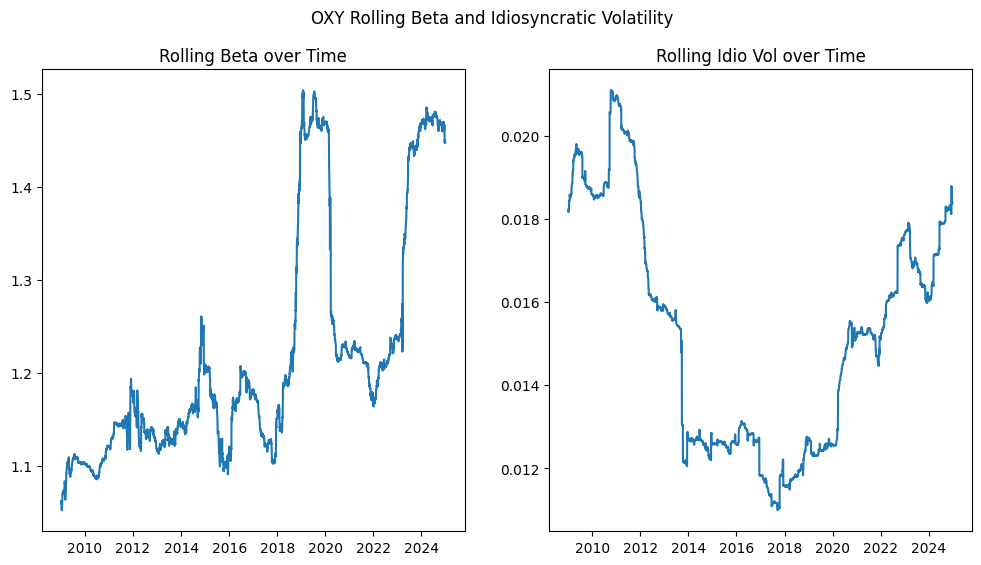

In [106]:

print(np.std(rolling_beta))
print(np.std(rolling_idio_vol))

fig, ax = plt.subplots(1,2, figsize = (12,6))

ax[0].plot(rolling_results['Beta'])
ax[0].set_title("Rolling Beta over Time")
ax[1].plot(rolling_results['Idiosyncratic Volatility'])
ax[1].set_title("Rolling Idio Vol over Time")
fig.suptitle('OXY Rolling Beta and Idiosyncratic Volatility')
plt.show()




In [76]:
rolling_pd = testing['merton_pd'][first:last].rolling(window=252*3, min_periods=252*2).mean()

first2 = max(rolling_pd.index[0], rolling_results.index[0])
last2 = min(rolling_pd.index[-1], rolling_results.index[-1])


In [84]:
X2 = sm.add_constant(rolling_results[first2:last2])
model2 = sm.OLS(rolling_pd[first2:last2], X2)
results2 = model2.fit()

print(results2.summary())

_, b, iv = results2.params

                            OLS Regression Results                            
Dep. Variable:              merton_pd   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     6909.
Date:                Sat, 26 Apr 2025   Prob (F-statistic):               0.00
Time:                        20:50:35   Log-Likelihood:                 11231.
No. Observations:                4025   AIC:                        -2.246e+04
Df Residuals:                    4022   BIC:                        -2.244e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [86]:
print(b * np.std(rolling_beta))
print(iv * np.std(rolling_idio_vol))

0.003969749339034823
0.024850806670088158


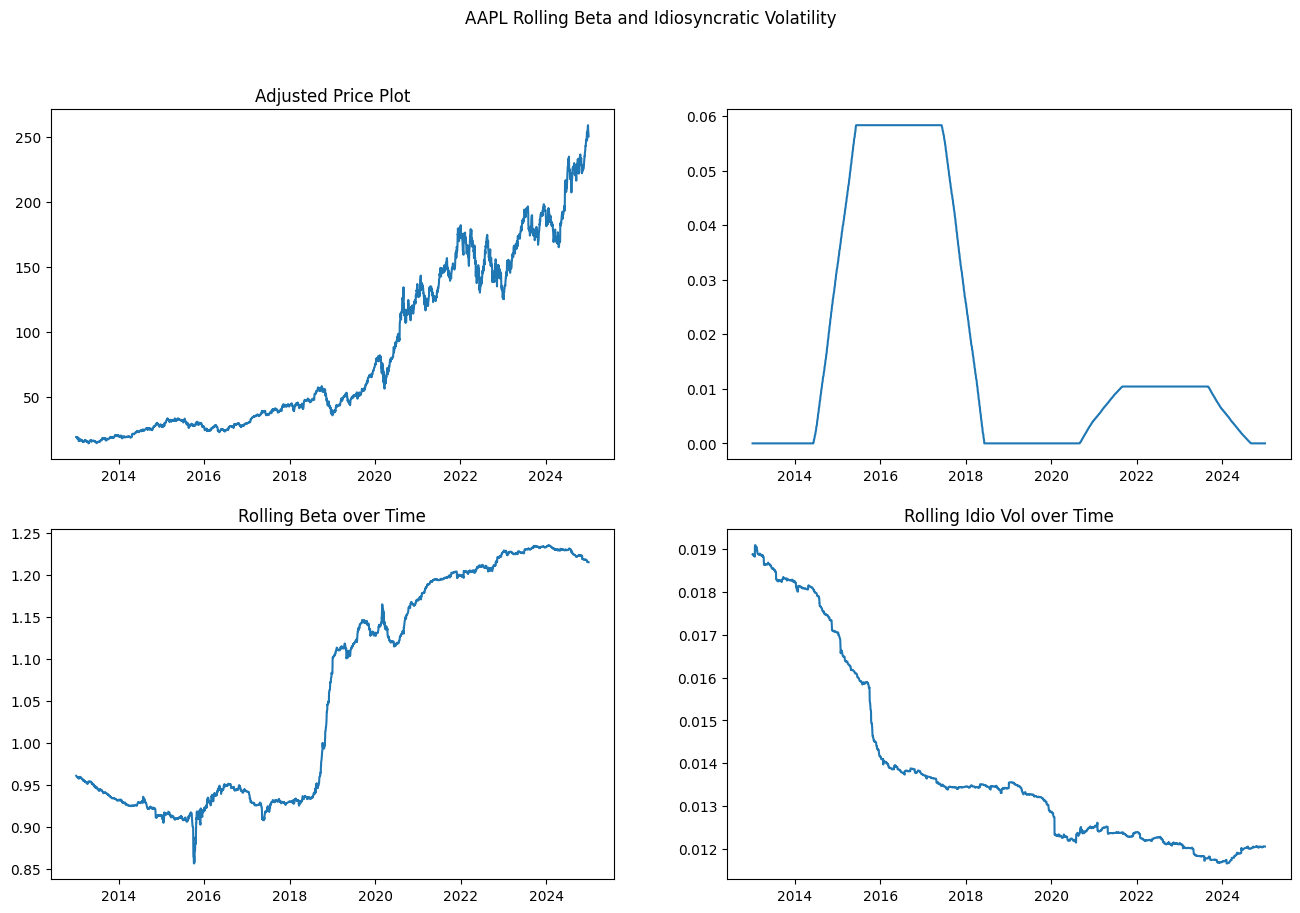

                            OLS Regression Results                            
Dep. Variable:              merton_pd   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     1666.
Date:                Sun, 27 Apr 2025   Prob (F-statistic):               0.00
Time:                        09:41:24   Log-Likelihood:                 8347.0
No. Observations:                3017   AIC:                        -1.669e+04
Df Residuals:                    3014   BIC:                        -1.667e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

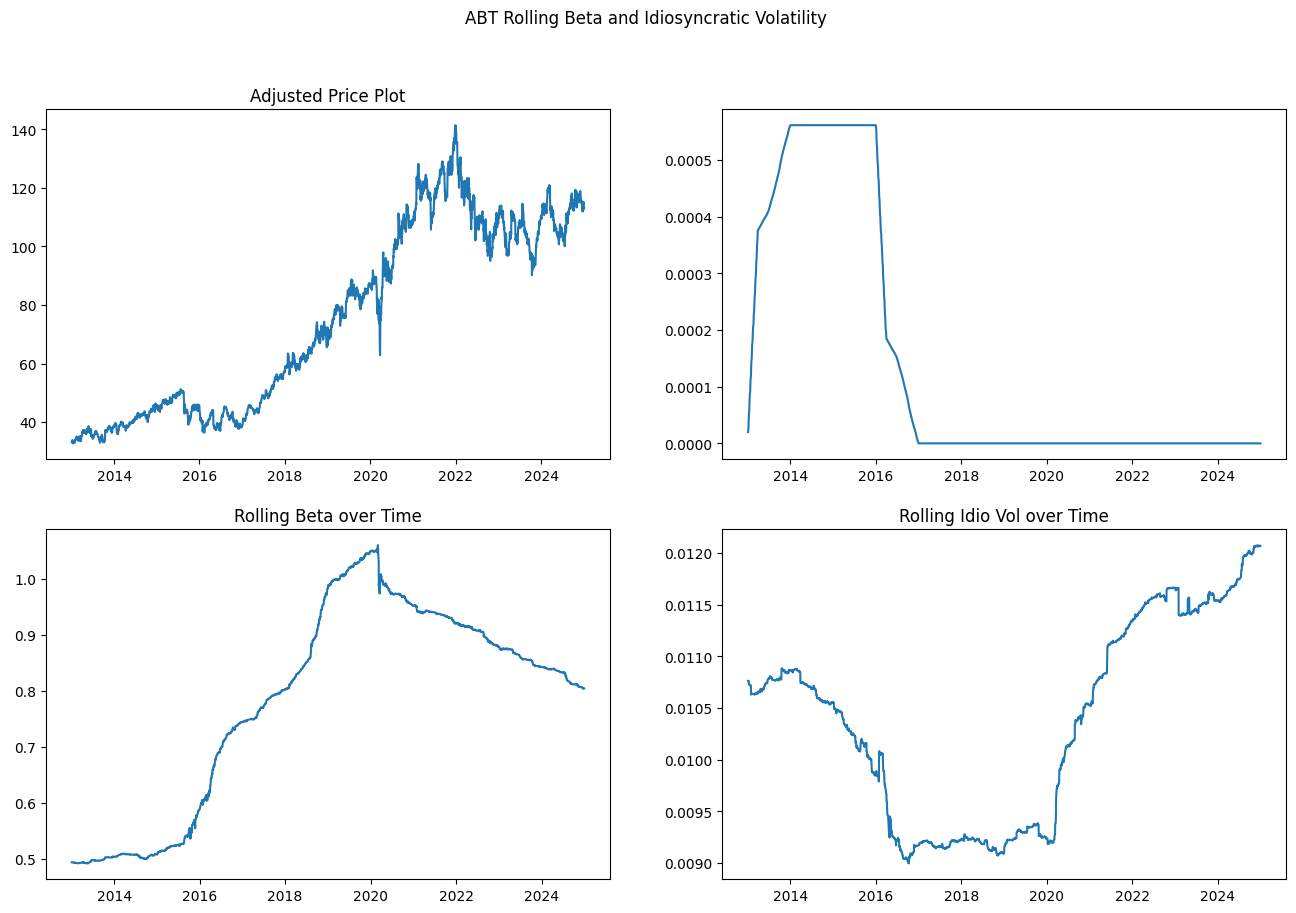

                            OLS Regression Results                            
Dep. Variable:              merton_pd   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     5335.
Date:                Sun, 27 Apr 2025   Prob (F-statistic):               0.00
Time:                        09:41:31   Log-Likelihood:                 23327.
No. Observations:                3017   AIC:                        -4.665e+04
Df Residuals:                    3014   BIC:                        -4.663e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

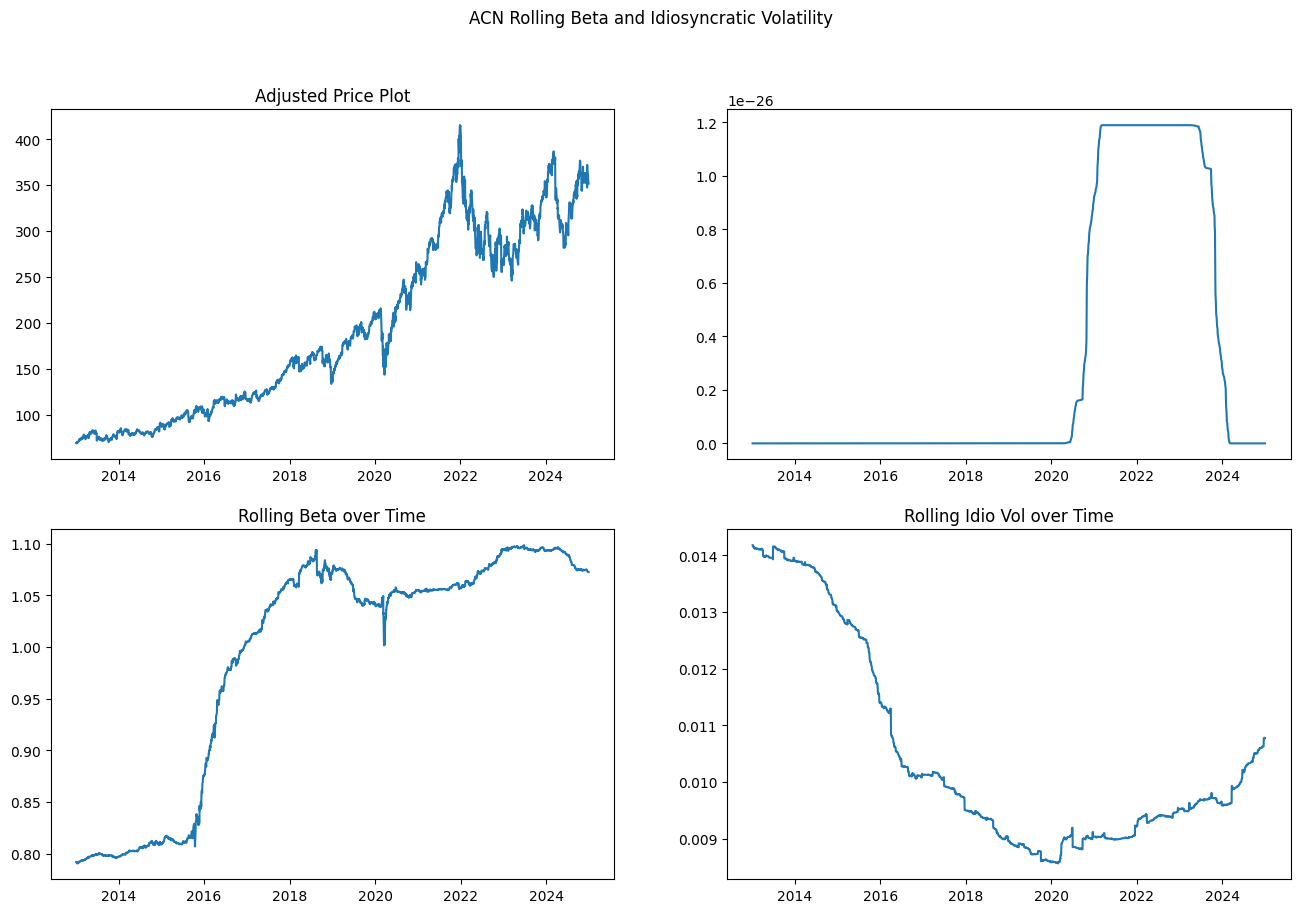

                            OLS Regression Results                            
Dep. Variable:              merton_pd   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     353.8
Date:                Sun, 27 Apr 2025   Prob (F-statistic):          9.25e-139
Time:                        09:41:38   Log-Likelihood:             1.7879e+05
No. Observations:                3017   AIC:                        -3.576e+05
Df Residuals:                    3014   BIC:                        -3.576e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

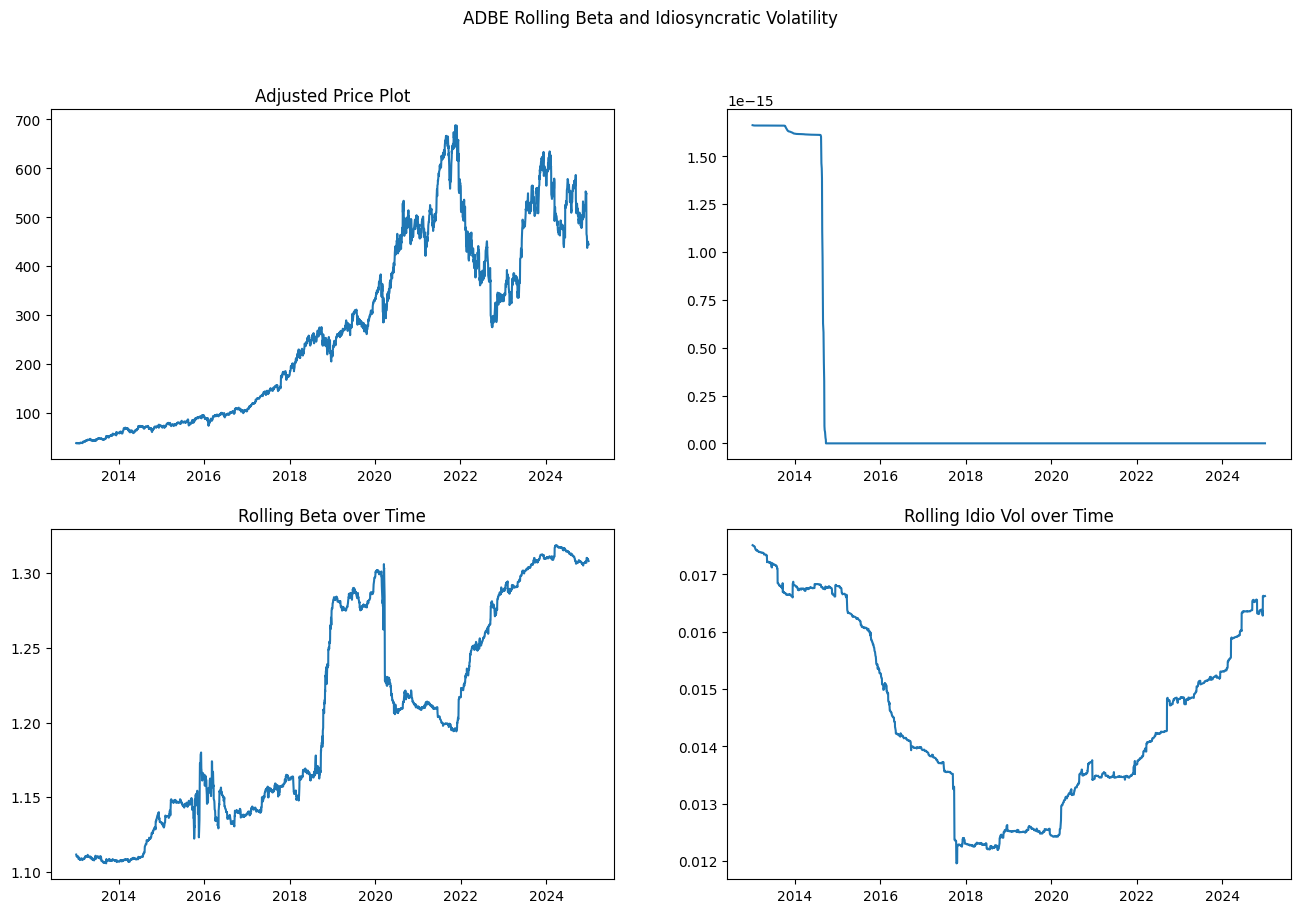

                            OLS Regression Results                            
Dep. Variable:              merton_pd   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     1465.
Date:                Sun, 27 Apr 2025   Prob (F-statistic):               0.00
Time:                        09:41:45   Log-Likelihood:             1.0269e+05
No. Observations:                3017   AIC:                        -2.054e+05
Df Residuals:                    3014   BIC:                        -2.054e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

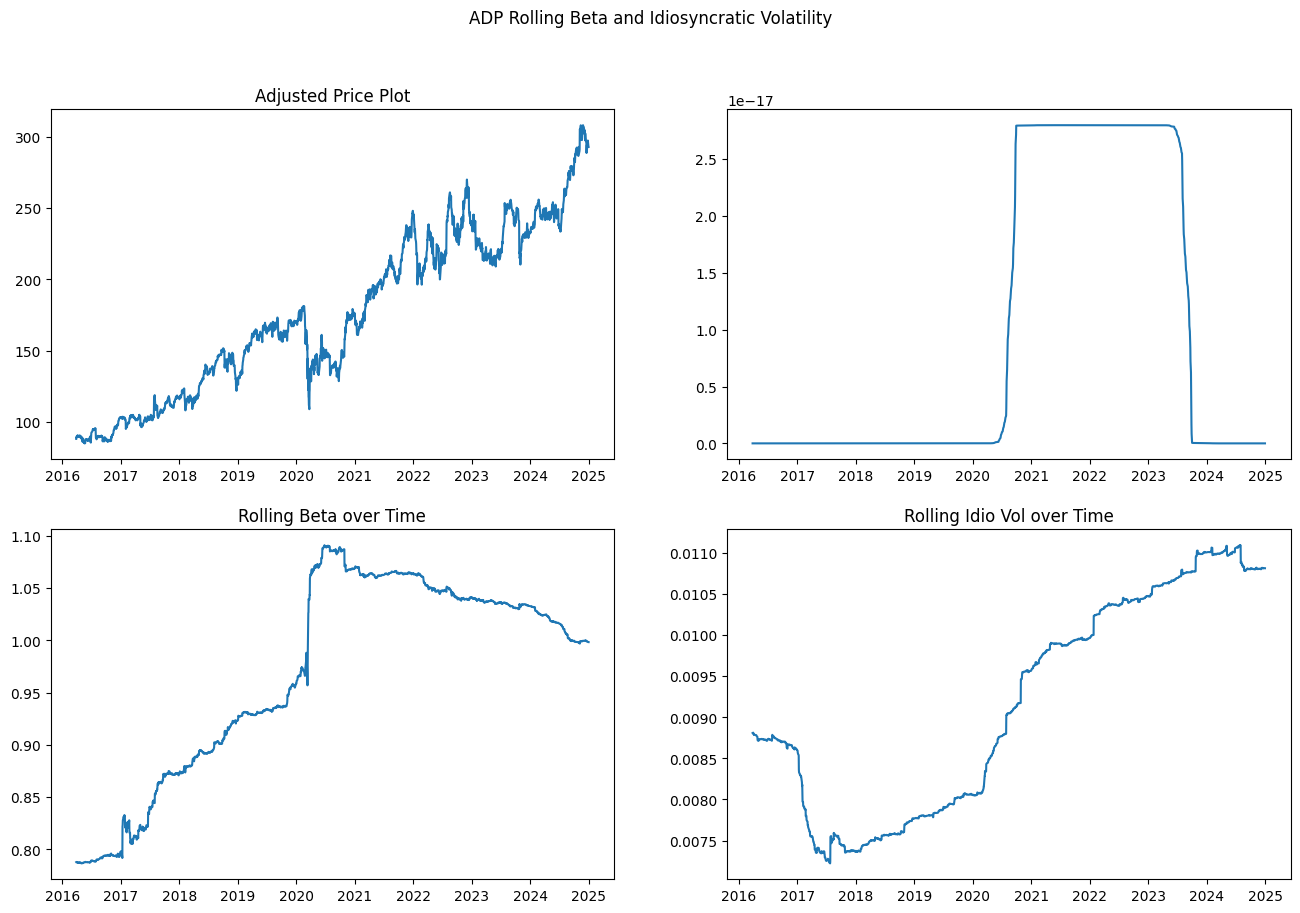

                            OLS Regression Results                            
Dep. Variable:              merton_pd   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     915.7
Date:                Sun, 27 Apr 2025   Prob (F-statistic):          3.60e-290
Time:                        09:41:51   Log-Likelihood:                 83310.
No. Observations:                2206   AIC:                        -1.666e+05
Df Residuals:                    2203   BIC:                        -1.666e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [ ]:
data = pd.read_csv(r'../data/clean_data.csv')
merton = pd.read_csv(r'../model/merton_model_output.csv')

spy_csv = pd.read_csv(r'../hypothesis-2/SPY.csv')
spy_csv['log_return'] = np.log(spy_csv['PRC'] / spy_csv['PRC'].shift(1))
spy_csv = spy_csv.set_index('date')
spy_csv.index = pd.to_datetime(spy_csv.index)

spy_logreturns = spy_csv['log_return'].dropna()


plot = True


for i in data['tic'].unique()[0:5]:

    stock = data[data['tic'] == str(i)]
    stock = stock.set_index('date')
    stock.index = pd.to_datetime(stock.index)


    probdef = merton[merton['tic'] == str(i)]
    probdef = probdef.set_index('date')
    probdef.index = pd.to_datetime(probdef.index)

    stock_logreturns = stock['log_return']


    spy_logreturns, stock_logreturns = spy_logreturns.align(stock_logreturns, join = 'inner', axis = 0)
    

    window_size = 252 * 7

    indices = spy_logreturns.index[window_size - 1:]
    stock_filter = stock.loc[indices]

    rolling_beta = []
    rolling_idio_vol = []
    rolling_dates = []

    for start in range(len(stock_logreturns) - window_size):
        end = start + window_size
        stock_window = stock_logreturns.iloc[start:end]
        market_window = spy_logreturns.iloc[start:end]
         
        X = sm.add_constant(market_window)
        y = stock_window
            
        model = sm.OLS(y, X)
        results = model.fit()
            
        _, beta = results.params
        residuals = results.resid
        idio_vol = np.std(residuals)
          
        rolling_beta.append(beta)
        rolling_idio_vol.append(idio_vol)
          
        rolling_dates.append(stock_window.index[-1])

    rolling_results = pd.DataFrame({
        'Date': rolling_dates,
        'Beta': rolling_beta,
        'Idiosyncratic Volatility': rolling_idio_vol
    })
    rolling_results.set_index('Date', inplace=True)

    rolling_pd = probdef['merton_pd'].rolling(window=252*3, min_periods=252*2).mean()

    rolling_pd_filt, rolling_results_filt = rolling_pd.align(rolling_results, join = 'inner', axis = 0)

    if plot == True:
        fig, ax = plt.subplots(2,2, figsize = (16,10))

        ax[1,0].plot(rolling_results['Beta'])
        ax[1,0].set_title("Rolling Beta over Time")
        ax[1,1].plot(rolling_results['Idiosyncratic Volatility'])
        ax[1,1].set_title("Rolling Idio Vol over Time")
        ax[0,0].plot(stock_filter['PRC'])
        ax[0,0].set_title('Adjusted Price Plot')
        ax[0,1].plot(rolling_pd_filt)
        fig.suptitle(f'{i} Rolling Beta and Idiosyncratic Volatility')
        plt.show()


    #########################################################################################

    


    X2 = sm.add_constant(rolling_results_filt)
    model2 = sm.OLS(rolling_pd_filt, X2)
    results2 = model2.fit()

    print(results2.summary())

    _, b, iv = results2.params
    print(f"{i} Beta: {b}")
    print(f"{i} IV: {iv}")



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     14.81
Date:                Sun, 27 Apr 2025   Prob (F-statistic):           2.74e-06
Time:                        10:11:29   Log-Likelihood:                 224.85
No. Observations:                  93   AIC:                            -443.7
Df Residuals:                      90   BIC:                            -436.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

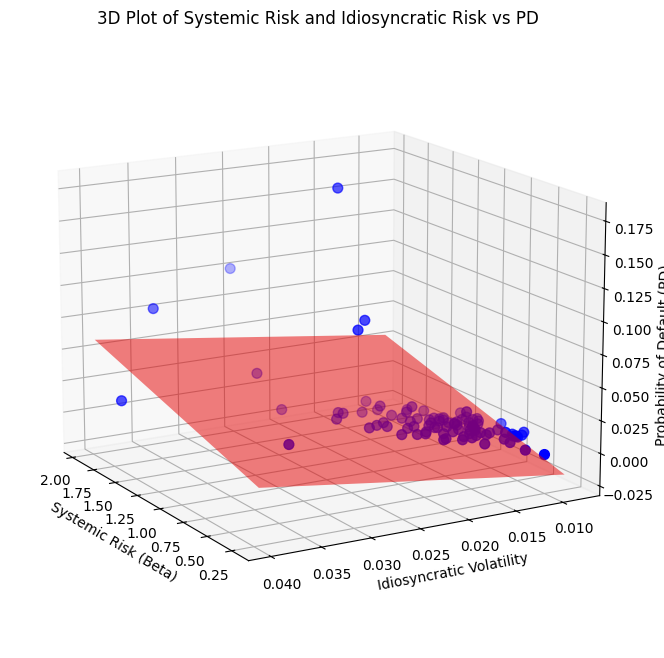

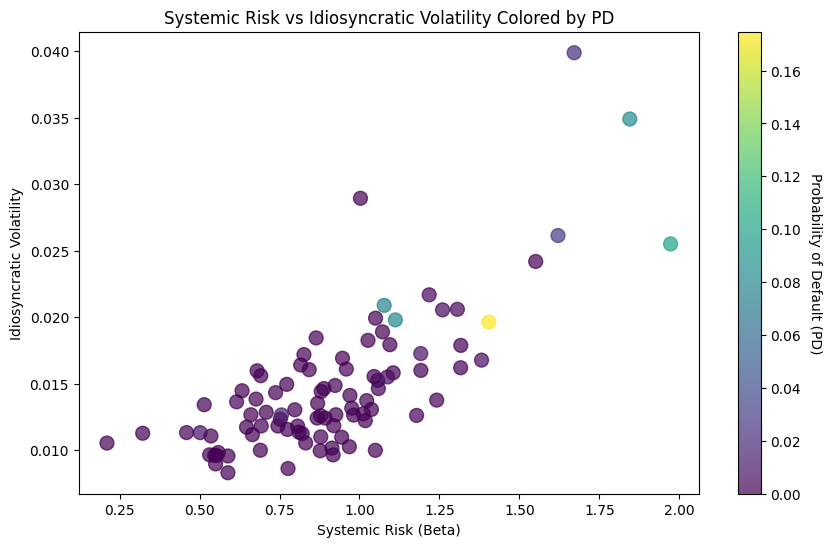

In [ ]:
data = pd.read_csv(r'../data/clean_data.csv')
merton = pd.read_csv(r'../model/merton_model_output.csv')

spy_csv = pd.read_csv(r'../hypothesis-2/SPY.csv')
spy_csv['log_return'] = np.log(spy_csv['PRC'] / spy_csv['PRC'].shift(1))
spy_csv = spy_csv.set_index('date')
spy_csv.index = pd.to_datetime(spy_csv.index)

spy_logreturns = spy_csv['log_return'].dropna()


plot = False

beta_set = []
iv_set = []
pd_set = []

tics = data['tic'].unique()
tics = np.delete(tics, 18) ## BRK.B messes everything up



for i in tics:

    stock = data[data['tic'] == str(i)]
    stock = stock.set_index('date')
    stock.index = pd.to_datetime(stock.index)

    probdef = merton[merton['tic'] == str(i)]
    probdef = probdef.set_index('date')
    probdef.index = pd.to_datetime(probdef.index)
    #print(probdef.index.duplicated().sum())


    stock_logreturns = stock['log_return']


    spy_logreturns, stock_logreturns = spy_logreturns.align(stock_logreturns, join = 'inner', axis = 0)
    
         
    X = sm.add_constant(spy_logreturns)
    y = stock_logreturns
            
    model = sm.OLS(y, X)
    results = model.fit()
         
    _, beta = results.params
    residuals = results.resid
    idio_vol = np.std(residuals)
        
    beta_set.append(beta)
    iv_set.append(idio_vol)


    
    probdefff = probdef['merton_pd'].reindex(stock_logreturns.index)

    pdd = probdefff.mean()
    pd_set.append(pdd)

    if plot == True:
        fig, ax = plt.subplots(2,2, figsize = (16,10))

        ax[1,0].plot(rolling_results['Beta'])
        ax[1,0].set_title("Rolling Beta over Time")
        ax[1,1].plot(rolling_results['Idiosyncratic Volatility'])
        ax[1,1].set_title("Rolling Idio Vol over Time")
        ax[0,0].plot(stock_filter['PRC'])
        ax[0,0].set_title('Adjusted Price Plot')
        ax[0,1].plot(rolling_pd_filt)
        fig.suptitle(f'{i} Rolling Beta and Idiosyncratic Volatility')
        plt.show()


    #########################################################################################

rolling_results = pd.DataFrame({
        'Beta': beta_set,
        'Idiosyncratic Volatility': iv_set
    })   


X2 = sm.add_constant(rolling_results)
model2 = sm.OLS(pd_set, X2)
results2 = model2.fit()

print(results2.summary())

a, b, iv = results2.params
print(f"Beta: {b*np.std(beta_set)}")
print(f"IV: {iv*np.std(iv_set)}" )

"""fig, ax = plt.subplots(2,2, figsize = (16,10))

ax[1,0].plot(rolling_results['Beta'])
ax[1,0].set_title("Systemic Risk")
ax[1,1].plot(rolling_results['Idiosyncratic Volatility'])
ax[1,1].set_title("Idiosyncratic Risk")
ax[0,0].plot(pd_set)
ax[0,0].set_title('Mean Default Probabilities')
#ax[0,1].plot(rolling_pd_filt)
fig.suptitle(f'{i} Rolling Beta and Idiosyncratic Volatility')"""


############################################################################################


fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111,projection='3d')

ax.scatter(beta_set, iv_set, pd_set, color = 'b', s = 50)

x_range = np.linspace(min(beta_set), max(beta_set), 100)
y_range = np.linspace(min(iv_set), max(iv_set), 100)
X_grid, Y_grid = np.meshgrid(x_range, y_range)
Z_grid = a + b * X_grid + iv * Y_grid

# Plot the surface of the regression plane
ax.plot_surface(X_grid, Y_grid, Z_grid, color='r', alpha=0.5, rstride=100, cstride=100)

# Labels and title
ax.set_xlabel('Systemic Risk (Beta)')
ax.set_ylabel('Idiosyncratic Volatility')
ax.set_zlabel('Probability of Default (PD)')
ax.set_title('3D Plot of Systemic Risk and Idiosyncratic Risk vs PD')

ax.view_init(elev=15, azim=90+60)
plt.show()
######################################################################################

plt.figure(figsize=(10, 6))

scatter = plt.scatter(beta_set, iv_set, c=pd_set, cmap='viridis', s=100, alpha=0.7)

cbar = plt.colorbar(scatter)
cbar.set_label('Probability of Default (PD)', rotation=270, labelpad=15)

# Labels and title
plt.xlabel('Systemic Risk (Beta)')
plt.ylabel('Idiosyncratic Volatility')
plt.title('Systemic Risk vs Idiosyncratic Volatility Colored by PD')



plt.show()
